In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch

from inference import Inference

In [2]:
# Initialize the Inference class (to automatically load the VAE and Classifier)
inf = Inference()

# Random test data for testing
test_samples = ["B001RQGBGI", "ABC-12345-XY", "!!!INVALID!!!", "010"]

In [3]:
print("Testing filtering logic...")
mask = inf.filter_inference_list(test_samples, inf.data_filters)
for s, m in zip(test_samples, mask):
    status = "PASS" if m else "FAIL (Invalid Structure)"
    print(f"Input: {s:15} | Status: {status}")
valid_only = [test_samples[i] for i, m in enumerate(mask) if m]

Testing filtering logic...
Input: B001RQGBGI      | Status: PASS
Input: ABC-12345-XY    | Status: PASS
Input: !!!INVALID!!!   | Status: PASS
Input: 010             | Status: FAIL (Invalid Structure)


In [4]:
print("Looking at a padded output...")
test_str = "ABC-123-09"
padded = inf.data_creator.pad_truncate_data([test_str], inf.train_max_length, inf.char2idx)

print(f"Input String: {test_str}")
print(f"Padded Shape: {padded.shape} (Expected: (1, {inf.train_max_length}))")
print(f"Integer Sequence: {padded[0]}") # We should see 4 padded tokens
assert padded.shape == (1, inf.train_max_length), "Shape mismatch in preprocessing."

Looking at a padded output...
Input String: ABC-123-09
Padded Shape: (1, 14) (Expected: (1, 14))
Integer Sequence: [14 15 16  3  5  6  7  3  4 13  0  0  0  0]


In [5]:
print("Testing VAE feature extraction...")
score_vector, debug_info = inf.extract_features_inference(valid_only, inf.vae)
for original, decoded in zip(valid_only, debug_info['reconstructions']):
    print(f"Original: {original}")
    print(f"VAE Reconstruction: {decoded}")

print(f"\nScore Vector Shape: {score_vector.shape} (Expected [N, 5])")
print(f"Sample Score Vector (Raw): {score_vector[0].cpu().numpy()}")

print("Testing encoder consistency...")
score1, _ = inf.extract_features_inference(["ABC-1234567"], inf.vae)
score2, _ = inf.extract_features_inference(["ABC-1234567"], inf.vae)
diff = torch.abs(score1 - score2).sum().item()
print(f"Difference between two identical runs: {diff:.10f}")
assert diff < 1e-6, "Model inconsistent. Check .eval() mode."

Testing VAE feature extraction...
Original: B001RQGBGI
VAE Reconstruction: B001RQGBGI
Original: ABC-12345-XY
VAE Reconstruction: ABC-12345-XY
Original: !!!INVALID!!!
VAE Reconstruction: <UNK><UNK><UNK>INVALID<UNK><UNK><UNK>

Score Vector Shape: torch.Size([3, 5]) (Expected [N, 5])
Sample Score Vector (Raw): [ 2.1710548 16.44466    0.7        0.3        0.       ]
Testing encoder consistency...
Difference between two identical runs: 0.0000000000


Fixed a bug revealed in the above unit test: Same input gave different results. Upon further research, it turned out I was using the reparameterization method even during evaluation mode, which introduces random noise to the distribution. This is good for training so the model learns a latent space and not a single point, but makes the results non-deterministic for evaluation and inference.

RL and KL Divergence scores seem to be far apart, normalization is required to make them comparable with the rest of the scores.

In [6]:
print("Testing score scaling & classification...")
scaled_scores = (score_vector - inf.mean) / (inf.std + 1e-7) # 1e-7 to prevent div by zero
print("Scaled Score Vector (Raw):", scaled_scores[0].cpu().numpy())
with torch.no_grad():
    probs = inf.classifier(scaled_scores).squeeze()
    if probs.dim() == 0: probs = probs.unsqueeze(0)

for s, p in zip(valid_only, probs):
    pred = "yes (valid)" if p >= 0.5 else "no (invalid)"
    print(f"ID: {s} | Prob: {p:.4f} | Prediction: {pred}")

Testing score scaling & classification...
Scaled Score Vector (Raw): [-1.5037831  -0.14740431  0.13784108  0.11577325 -0.5272762 ]
ID: B001RQGBGI | Prob: 0.7913 | Prediction: yes (valid)
ID: ABC-12345-XY | Prob: 0.0250 | Prediction: no (invalid)
ID: !!!INVALID!!! | Prob: 0.0009 | Prediction: no (invalid)


In [7]:
print("Testing batch independence...")
single_score, _ = inf.extract_features_inference([test_samples[0]], inf.vae)
batch_scores, _ = inf.extract_features_inference(test_samples, inf.vae)
diff = torch.abs(single_score[0] - batch_scores[0]).sum().item()
print(f"Batch vs Single independence diff: {diff:.10f}")
assert diff < 1e-6, "Batch performs differently. Check tensor reshaping logic."

Testing batch independence...
Batch vs Single independence diff: 0.0000000000


In [8]:
print("Testing input signal sensitivity...")
clean_id = "ABC-1234567"
dirty_id = "ABC!1234567" # Replaced '-' with '!'
score_clean, _ = inf.extract_features_inference([clean_id], inf.vae)
score_dirty, _ = inf.extract_features_inference([dirty_id], inf.vae)
recon_jump = score_dirty[0, 0] - score_clean[0, 0]
print(f"Recon Error Jump after 1-char corruption: {recon_jump:.4f}") # Positive jump signals that the VAE successfully flagged the structural anomaly

Testing input signal sensitivity...
Recon Error Jump after 1-char corruption: 0.0284


Visualize the last training history...


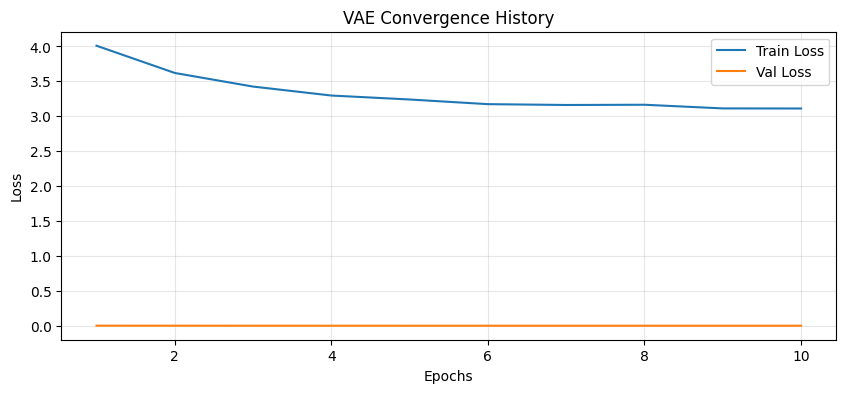

In [9]:
print("Visualize the last training history...")
log_path = os.path.join(inf.training_history, "local_logs", "vae_training_metrics.csv")
if os.path.exists(log_path):
    history = pd.read_csv(log_path)
    plt.figure(figsize=(10, 4))
    plt.plot(history['epoch'], history['train_loss'], label='Train Loss')
    plt.plot(history['epoch'], history['val_loss'], label='Val Loss')
    plt.title("VAE Convergence History")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Training log CSV not found. Re-run training.")